## Credit Risk Analysis By Default Prediction On Credit Card Accounts

### Introduction To Default Prediction

Before customers encounter actual financial difficulties, there are indicators which can be used to anticipate the final default outcome, such as late payments, calls to the customer services, enquiries about the products and a different browsing pattern on the web or mobile app. By using such patterns, it is possible to prevent or guide the process and provide a better service to the customer as well as reduce risks for the bank.

This paper talks about credit card default prediction using Decision Tree Ensemble based Supervised Machine Learning algorithms, in particular, the RandomForest and GradientBoostedTree algorithms. 

### Synopysis

This notebook unfolds in the following phases:   
(1) Data Loading;    
(2) Data Cleaning;    
(3) Descriptive Statistics;    
(4) Feature Engineering;    
(5) Feature Selection;  
(6) Model Training;   
(7) Model Testing and    
(8) Model Interpretation.    

### Modeling

We will compare the predictive power of 2 classes of Supervised Learning algorithms:   
(1) RandomForests;     
(2) GradientBoosted Trees.    

### Source

The dataset is availble at the Center for Machine Learning and Intelligent Systems, Bren School of Information and Computer Science, University of California, Irvine: 
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Citation:
Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

### Data Loading

We cache the data set from the above mentioned repository in a local directory.

In [2]:
#data import
import wget
import urllib3

# regex
import re

#time
import pytz as tz
from datetime import datetime

#data explore
import numpy as np
np.random.seed(1337)

#support for reading excel files
import xlrd

# dataframes in python
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

In [4]:
import os
import shutil

datadir = 'C:/Kal/Stat-Work/Stat-Code/SciKit/FraudDetection'
if not os.path.exists(datadir):
    os.makedirs(datadir)

In [5]:
# Get the dataset from UCI

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls' 
filename = os.path.join(datadir, 'Credit_Card_Database.xls')

if not os.path.isfile(filename):
    wget.download(url, out=filename)
    

### Data Cleaning

We use pandas to read the data from its original excel format into a dataframe.

In [6]:
df = pd.read_excel(filename, header=1)

We lowercase the column name, and rename the column names where required. In particular, remarkably, this dataset misses a colum PAY_1. In the analysis below, we assume that PAY_0 is actually PAY_1, to consider the repayment of the month prior to the month when we calculate the defaulting probability. 

In [7]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

In [8]:
print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'target'))

Explanatory variables:  23
Number of Observations: 30000
Target variable:       'default payment next month' -> 'target'


#### Attributes description

This study uses 23 variables as explanatory variables, extracted/interpreted from:   
(1) limit_bal: Amount of the given credit: It includes both the individual consumer credit and his/her family (supplementary) credit.      
(2) sex: Gender: (1 = male; 2 = female)   
(3) education: (1 = graduate school; 2 = university; 3 = high school; 4 = others)    
(4) marriage:  (1 = married; 2 = single; 3 = others)     
(5) age: Age (years)     
(6) pay_1 - pay_6:       
    History of past payment (Past monthly payment records).    
    From April to September, 2005 as follows:       
    pay_1 - the repayment status in September, 2005    
    pay_2 = the repayment status in August, 2005    
    ...   
    pay_6 = the repayment status in April, 2005    

The measurement scale for the repayment status is:    
-1 = pay duly;        
1 = payment delay for one month        
2 = payment delay for two months       
...      
8 = payment delay for eight months        
9 = payment delay for nine months and above       

(7) bill_amt1-bill_amt5:
    Amount of bill statement.           
    bill_amt1 = amount of bill statement in September, 2005        
    bill_amt2 = amount of bill statement in August, 2005        
    ...        
    bill_amt5 = amount of bill statement in May, 2005         

(8) pay_amt1-pay_amt5:
    Amount of previous payment:   
    pay_amt1 = amount paid in September, 2005        
    pay_amt2 = amount paid in August, 2005          
    ...             
    pay_amt5 = amount paid in May, 2005           



### Descriptive Statistics
##### Payment Delays

Let's start by looking at the past payment delays.

In [9]:
# Payment status columns - Descriptive Statistics.
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [x for x in df.columns if (pattern.match(x))]

df[pay_status_columns].describe()

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [13]:
df[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,-1,-1,0,0,-1
8,0,0,2,0,0,0
9,-2,-2,-2,-2,-1,-1


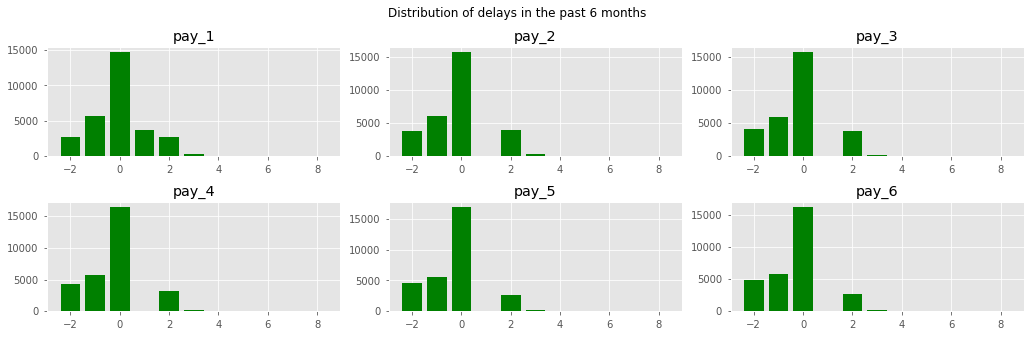

In [10]:
# Pay status columns - Exploratory Analysis.
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of delays in the past 6 months')

# Cannot use ax.hist() method since bins do not increase monotonically.
# Use ax.bar() method to plot.
for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3
    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

In [11]:
# Pay Amount columns - Descriptive Statistics.
pattern = re.compile("^pay_amt[0-9]+$")
pay_amt_columns = [x for x in df.columns if (pattern.match(x))]

df[pay_amt_columns].describe()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [11]:
df[pay_amt_columns].head(10)

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,0,689,0,0,0,0
1,0,1000,1000,1000,0,2000
2,1518,1500,1000,1000,1000,5000
3,2000,2019,1200,1100,1069,1000
4,2000,36681,10000,9000,689,679
5,2500,1815,657,1000,1000,800
6,55000,40000,38000,20239,13750,13770
7,380,601,0,581,1687,1542
8,3329,0,432,1000,1000,1000
9,0,0,0,13007,1122,0


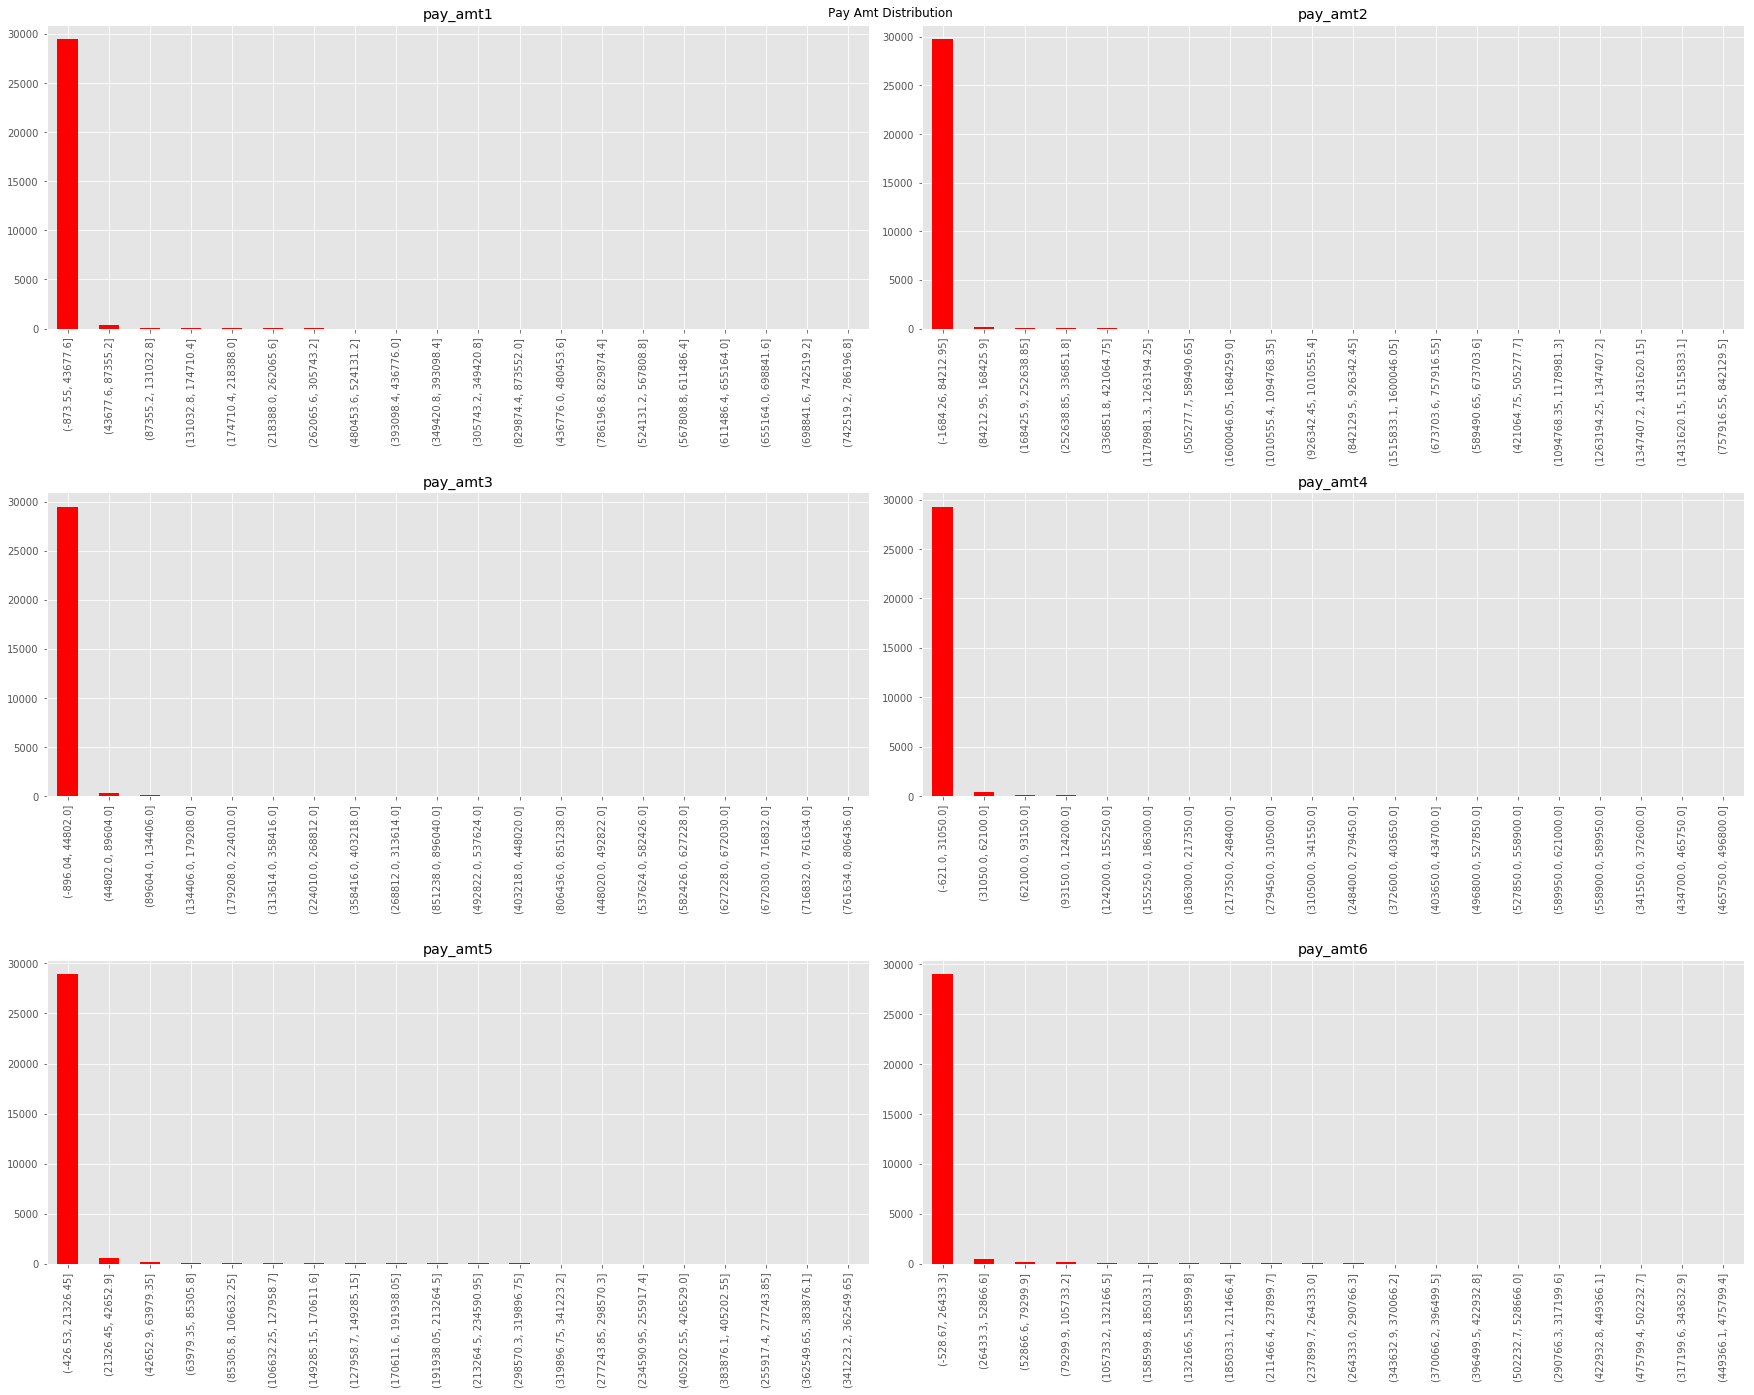

In [12]:
# Pay Amount columns - Exploratory Analysis.
pattern = re.compile("^pay_amt[0-9]+$")
pay_amt_columns = [x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(3, 2)
fig.suptitle('       Pay Amt Distribution')
fig.set_size_inches(25, 20)

# Use a bar graph.
for i in range(len(pay_amt_columns)):
    row,col = int(i/2), i%2
    d  = pd.value_counts(pd.cut(df[pay_amt_columns[i]], 20, precision=2))
    d.plot(kind='bar', ax=ax[row, col], color='r', title=pay_amt_columns[i])

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()

As you can see, some people pay 2 month upfront, others are one month upfront and most of them are on par. A few are running behind payments. The Pay Amount column distributions are extremely skewed right. 


#### Standing credit

Let's look at how the debts/credits are accumulating over the months. Credit to be repaid is a positive number here.


In [15]:
# Bill columns - Descriptive Analysis.
pattern = re.compile("^bill_amt[0-9]+$")
bill_columns = [ x for x in df.columns if (pattern.match(x))]

df[bill_columns].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [14]:
df[bill_columns].head(10)

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
0,3913,3102,689,0,0,0
1,2682,1725,2682,3272,3455,3261
2,29239,14027,13559,14331,14948,15549
3,46990,48233,49291,28314,28959,29547
4,8617,5670,35835,20940,19146,19131
5,64400,57069,57608,19394,19619,20024
6,367965,412023,445007,542653,483003,473944
7,11876,380,601,221,-159,567
8,11285,14096,12108,12211,11793,3719
9,0,0,0,0,13007,13912


#### Explore Defaulting

Let's start with a zoomed out view on the problem.
We want to predict defaulting.

Let's answer the following question: 
(1) How many cases do we have on our dataset to work with?
(2) What is the breakdown based on the available variables?



Defaulting accounts are 22.12% out of 30000 observations


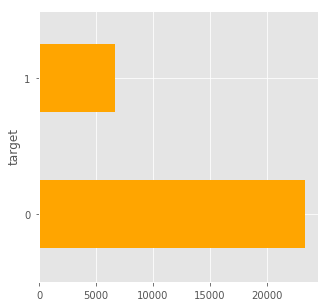

In [16]:
# Target is the response variable.
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()

print("Defaulting accounts are {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')

### Grouping Statistics Using Categorical Variables

Let's have a look at a number of histograms to see how defaulting correlated with the categorical variables available.

Prior to that, let's make use of categorical features of pandas by converting target, sex, marriage, education, age and the pay_* columns to categories.


In [17]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other']) 

df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False)

pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
for i in pay_status_columns:
    df[i] = df[i].astype('category')

#### Grouping based Absolute statistics for the population

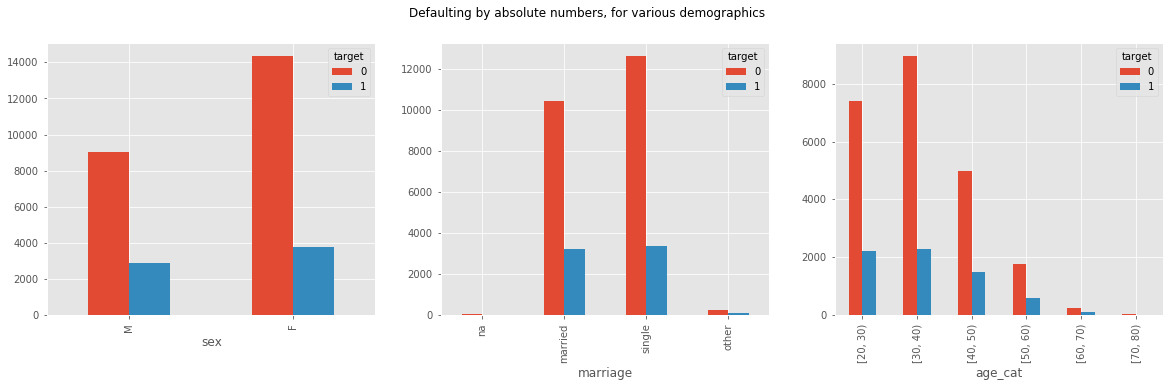

In [18]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = df.groupby(['target', 'sex']).size().unstack(level='target')
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level='target')
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level='target')
p = d.plot(kind='bar', ax=ax[2])

#### Grouping based Relative statistics for the population

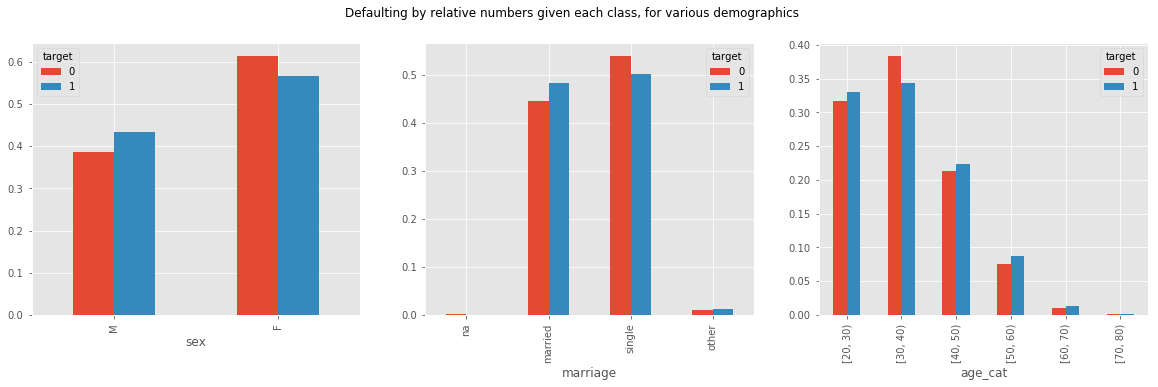

In [19]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = df.groupby(['target', 'sex']).size().unstack(level='target')
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level='target')
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level='target')
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

### Feature Transformation

We see that payment exibits a log distribution.

In [20]:
# help func
def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]


from math import log

# average and standard deviation payment status
df['pay_avg'] = df[selcols('pay_')].mean(axis=1)
df['pay_std'] = df[selcols('pay_')].std(axis=1)


In [21]:
# average payment
df['pay_amt_avg']     = df[selcols('pay_amt')].mean(axis=1)

# log of average
df['pay_amt_avg_log'] = df['pay_amt_avg'].apply(lambda x: log(x+1))

#amounts relative to the average payment
for i in np.arange(1,7):
    df['pay_relamt'+str(i)] = df['pay_amt'+str(i)]/df['pay_amt_avg']

# log of payments
for i in np.arange(1,7):
    df['pay_amt_log'+str(i)] = df['pay_amt'+str(i)].apply(lambda x: log(x+1))


In [22]:
# average bill
df['bill_amt_avg'] = df[selcols('bill_amt')].mean(axis=1)
df['bill_amt_avg_log'] = df['bill_amt_avg'].apply(lambda x: log(x+1) if x>0 else 0)

# bill sign as a separate feature
for i in np.arange(1,7):
    df['bill_amt_sign'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: float(x>0))
    
# bill log as a separate feature (0 if bill is negative)
for i in np.arange(1,7):
    df['bill_amt_log'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: log(x+1) if x>0 else 0)
    
#bill amounts relative to the limit
for i in np.arange(1,7):
    df['bill_relamt'+str(i)] = df['bill_amt'+str(i)]/df['limit_bal']


In [23]:
#log of credit limit
df['limit_bal_log'] = df['limit_bal'].apply(lambda x: log(x+1))
df['limit_bal_cat'] = pd.cut(df['limit_bal'], range(0, int(1e6), 10000), right=False)

### Using Dmatrices To Create Design Matrices

In [24]:
from patsy import dmatrices

formula  = 'target ~ '

# original features
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))

#### Engineered / Normalized features

# categorical age and credit limit (binned)
formula += '+' + 'C(age_cat)'
formula += '+' + 'C(limit_bal_cat) + limit_bal_log'

#pay delays
formula += '+' + 'pay_avg + pay_std'
    
#pay_amt
formula += '+' + 'pay_amt_avg_log'
formula += '+' + '+'.join(selcols('pay_relamt'))
formula += '+' + '+'.join(selcols('pay_amt_log'))

# bill amounts
formula += '+' + 'bill_amt_avg_log'
formula += '+' + '+'.join(selcols('bill_relamt'))
formula += '+' + '+'.join(selcols('bill_amt_sign'))
formula += '+' + '+'.join(selcols('bill_amt_log'))

y, X = dmatrices(formula, data=df, return_type='dataframe')
y = y.iloc[:, 1]


### Pipeline For Feature Scaling And Feature Selection

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Split into training and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = make_pipeline(MinMaxScaler(copy=True, feature_range=(0, 1)), 
                     SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median"))
pipe.fit(X_train, y_train)
X_train_selected = pipe.transform(X_train)
X_test_selected = pipe.transform(X_test)

print("X_train shape: ", X_train.shape)
print("X_train_selected shape: ", X_train_selected.shape)
print("X_test_selected shape: ", X_test_selected.shape)

X_train shape:  (22853, 211)
X_train_selected shape:  (22853, 106)
X_test_selected shape:  (5714, 106)


### Model Evaluation and Metric Visualization

In [35]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

### Model Training and Testing

In [36]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifier model object.
forest = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the model using the training sets.
forest.fit(X_train_selected, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Model Evaluation Using Metrics

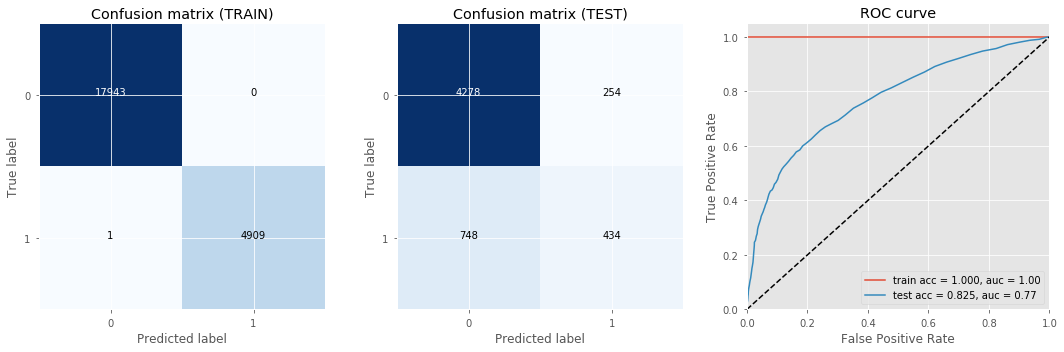

In [37]:
y_train_pred = forest.predict_proba(X_train_selected)[:,1]
y_test_pred = forest.predict_proba(X_test_selected)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

### ROC Curve For Model Evaluation

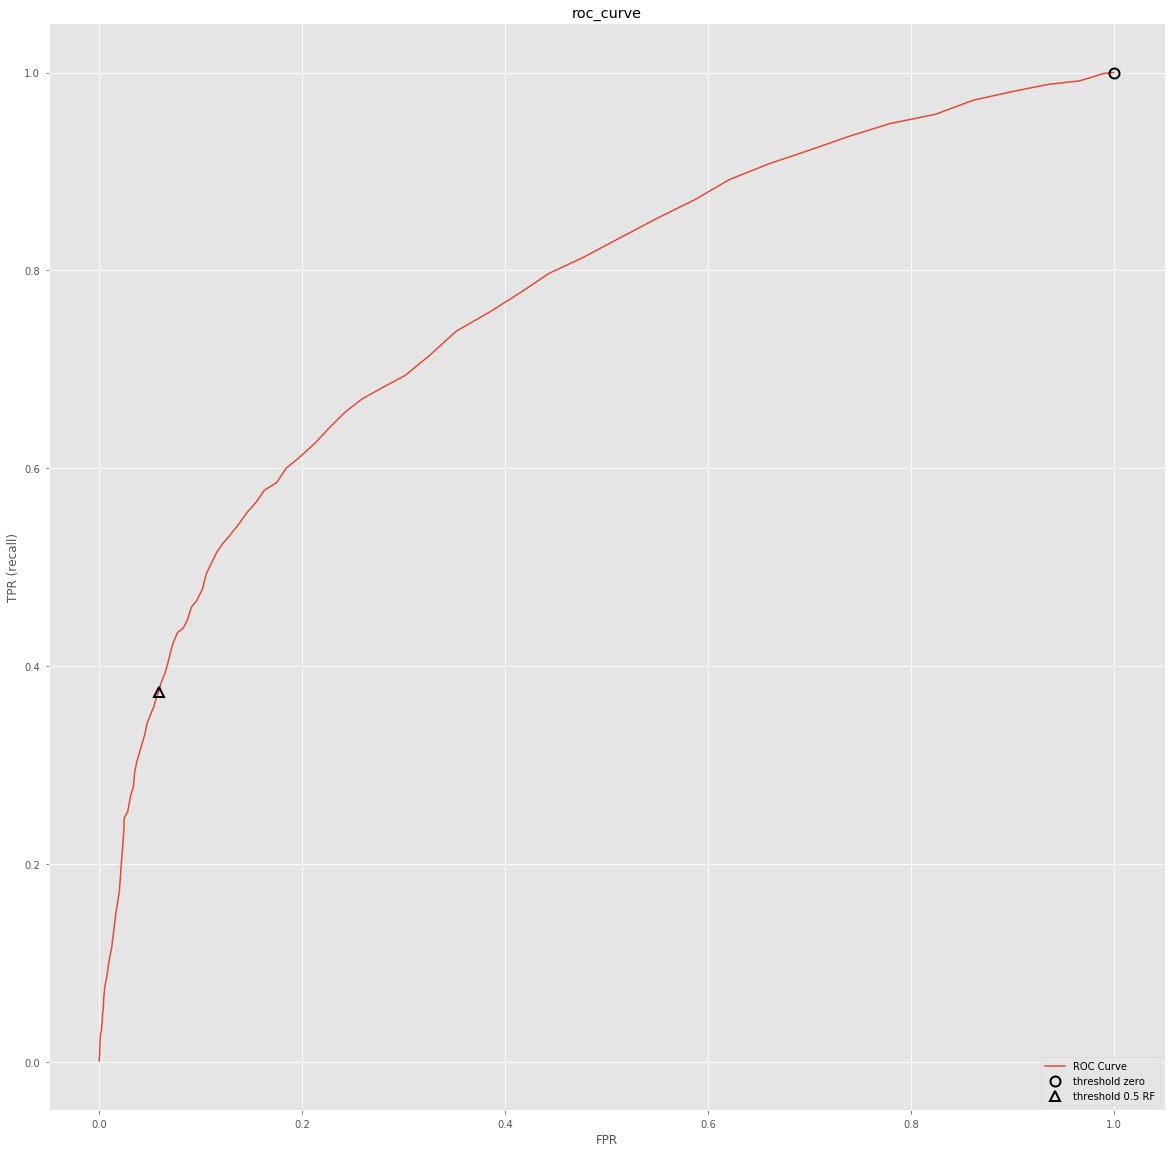

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds_rf = roc_curve(y_test, forest.predict_proba(X_test_selected)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("roc_curve")

# Find threshold closest to zero and default value of 0.5.
close_zero_rf = np.argmin(np.abs(thresholds_rf))
plt.plot(fpr_rf[close_zero_rf], tpr_rf[close_zero_rf], 'o', markersize=10, label="threshold zero", 
         fillstyle="none", c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10, 
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

### Model Training and Testing

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

# Create GBRT classifier model object.
gbrt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0)

# Train the model using the training sets.
gbrt.fit(X_train_selected, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

### Model Evaluation Using Metrics

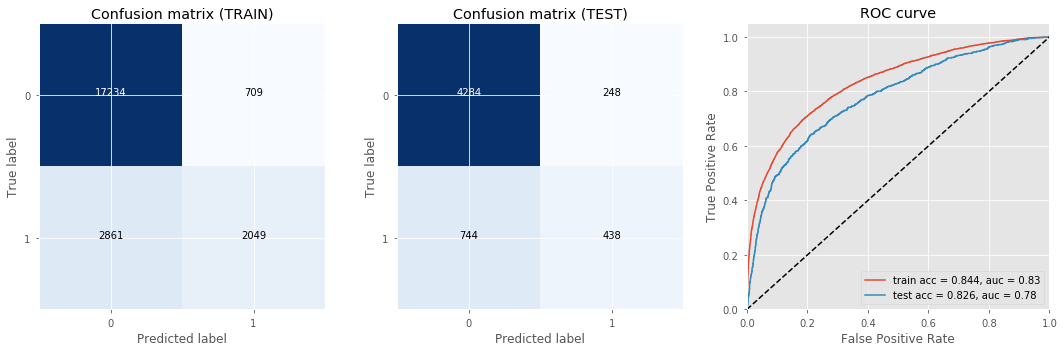

In [41]:
y_train_pred = gbrt.predict_proba(X_train_selected)[:,1]
y_test_pred = gbrt.predict_proba(X_test_selected)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

### ROC Curve For Model Evaluation And ROC Curve Comparison

AUC for RandomForest Model: 0.771293
AUC for GradientBoostedTree Model: 0.779120


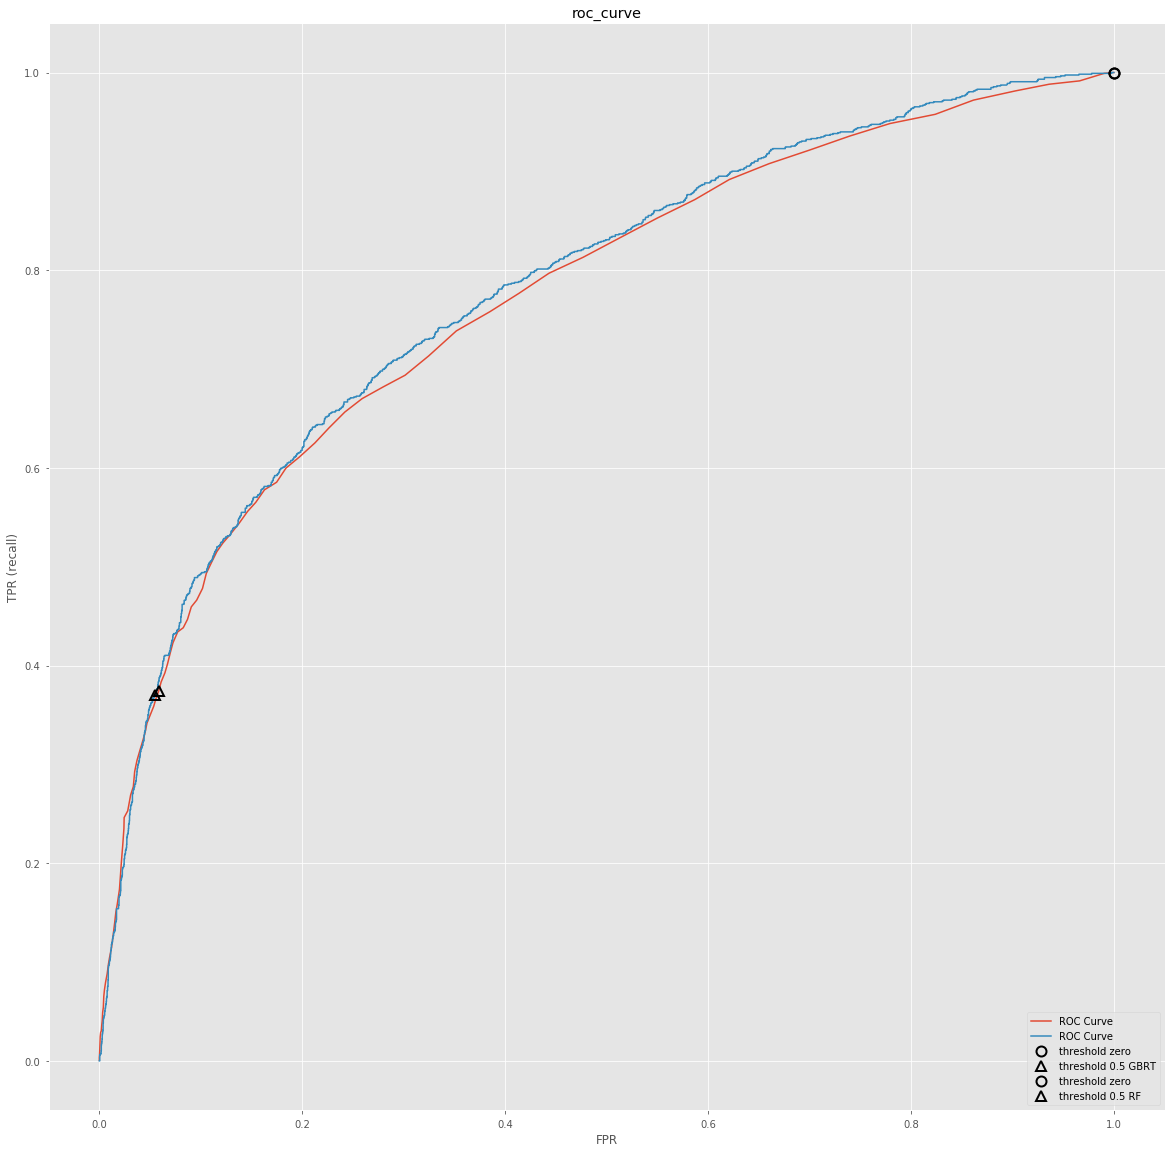

In [42]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, forest.predict_proba(X_test_selected)[:, 1])
plt.plot(fpr_rf, tpr_rf, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("roc_curve")

fpr_gbrt, tpr_gbrt, thresholds_gbrt = roc_curve(y_test, gbrt.predict_proba(X_test_selected)[:, 1])
plt.plot(fpr_gbrt, tpr_gbrt, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("roc_curve")

# Find threshold closest to zero and default value of 0.5.
close_zero_gbrt = np.argmin(np.abs(thresholds_gbrt))
plt.plot(fpr_gbrt[close_zero_gbrt], tpr_gbrt[close_zero_gbrt], 'o', markersize=10, label="threshold zero", 
         fillstyle="none", c='k', mew=2)

close_default_gbrt = np.argmin(np.abs(thresholds_gbrt - 0.5))
plt.plot(fpr_gbrt[close_default_gbrt], tpr_gbrt[close_default_gbrt], '^', markersize=10, 
         label="threshold 0.5 GBRT", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

# Find threshold closest to zero and default value of 0.5.
close_zero_rf = np.argmin(np.abs(thresholds_rf))
plt.plot(fpr_rf[close_zero_rf], tpr_rf[close_zero_rf], 'o', markersize=10, label="threshold zero", 
         fillstyle="none", c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10, 
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

# Find auc scores.
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, forest.predict_proba(X_test_selected)[:, 1])
gbrt_auc = roc_auc_score(y_test, gbrt.predict_proba(X_test_selected)[:,1])
print("AUC for RandomForest Model: %f" % rf_auc)
print("AUC for GradientBoostedTree Model: %f" % gbrt_auc)



### AUC Comparison And Conclusion
We can compute the area under the ROC curve using the roc_auc_score function. Comparing RandomForest and GradientBoostedTree models using the AUC score, we find that GradientBoostedTree model performs a bit better than RandomForest model. 

AUC for RandomForest Model: 0.771293   
AUC for GradientBoostedTree Model: 0.779120
